<a href="https://colab.research.google.com/github/AlinFin/Tumor/blob/main/brain_tumor_modified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)



In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import time

from sklearn.model_selection import train_test_split
import random
from tqdm import tqdm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# For ML Models
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from sklearn.metrics import confusion_matrix
import itertools
import pydot
import graphviz
from keras.utils import to_categorical



In [3]:
!pip install kaggle

In [4]:
#move the uploaded kaglle jason to the appropriate location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

 98% 146M/149M [00:07<00:00, 24.8MB/s]
100% 149M/149M [00:07<00:00, 19.7MB/s]


In [6]:
!unzip brain-tumor-mri-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/

In [7]:
# Define the path to the test and train datasets
train_dir = 'Training'
test_dir='Testing'

In [8]:
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']

In [9]:
# Go over the train dataset:
for i in categories:
    path = os.path.join(train_dir, i)
    for img in os.listdir(path):
        img_array_train = cv2.imread(os.path.join(path,img))

# Go over the test dataset:
for i in categories:
    path = os.path.join(test_dir, i)
    for img in os.listdir(path):
        img_array_test = cv2.imread(os.path.join(path,img))

In [10]:
#This is size of each image - 512x512 with 3 channels (RGB)
print(img_array_train.shape)
print(img_array_test.shape)

(512, 512, 3)
(512, 512, 3)


In [11]:
#Count the number of files in each directory

# Get a list of all files and folders in the directory
files_and_folders = os.listdir(train_dir) # ['glioma', 'meningioma', 'notumor', 'pituitary']
files_and_folders1 = os.listdir(test_dir)


# Count the number of pictures in each folder
train_categories = []
train_counts = []
for folder in files_and_folders:
    folder_path = os.path.join(train_dir, folder)
    num_pictures = len(os.listdir(folder_path))
    train_categories.append(folder)
    train_counts.append(num_pictures)
    print(f"Number of pictures in train folder {folder}: {num_pictures}")


# Count the number of pictures in each folder for testing dataset
test_categories = []
test_counts = []
for folder in files_and_folders1:
    folder_path = os.path.join(test_dir, folder)
    num_pictures = len(os.listdir(folder_path))
    test_categories.append(folder)
    test_counts.append(num_pictures)
    print(f"Number of pictures in test folder {folder}: {num_pictures}")



Number of pictures in train folder meningioma: 1339
Number of pictures in train folder notumor: 1595
Number of pictures in train folder glioma: 1321
Number of pictures in train folder pituitary: 1457
Number of pictures in test folder meningioma: 306
Number of pictures in test folder notumor: 405
Number of pictures in test folder glioma: 300
Number of pictures in test folder pituitary: 300


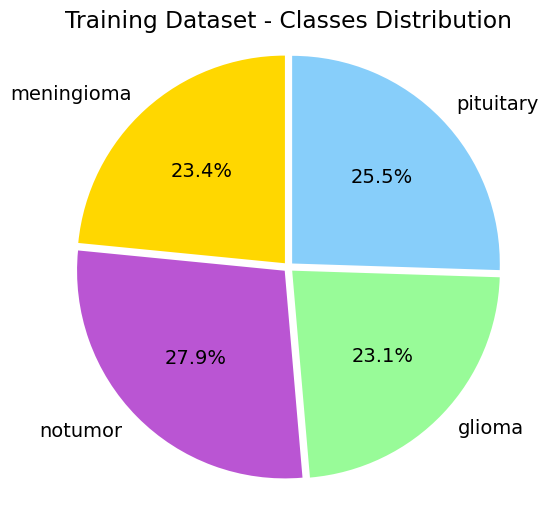

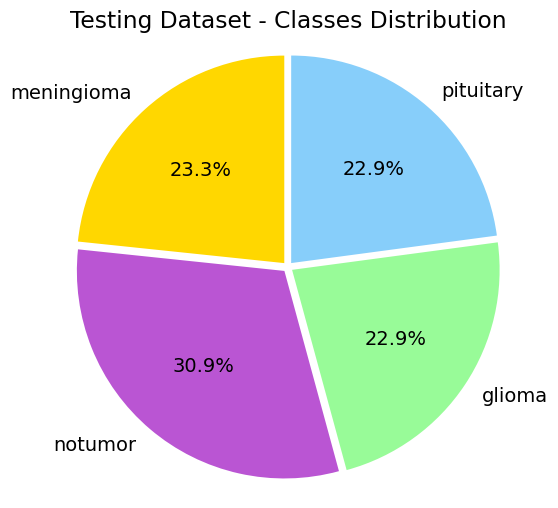

In [12]:
# Define custom colors for the pie chart

colors = ['gold', 'mediumorchid', 'palegreen', 'lightskyblue']

# Create a pie chart for the training dataset
plt.figure(figsize=(6, 6))
plt.rcParams.update({'font.size':14})
plt.pie(train_counts, labels=train_categories,colors=colors, autopct='%1.1f%%', explode=(0.025,0.025, 0.025,0.025),startangle=90)
plt.title('Training Dataset - Classes Distribution')
plt.axis('equal')
plt.show()

# Create a pie chart for the testing dataset
plt.figure(figsize=(6, 6))
plt.rcParams.update({'font.size':14})
plt.pie(test_counts, labels=test_categories,colors=colors, autopct='%1.1f%%', explode=(0.025,0.025, 0.025,0.025),startangle=90)
plt.title('Testing Dataset - Classes Distribution')
plt.axis('equal')
plt.show()


### The data is balanced.

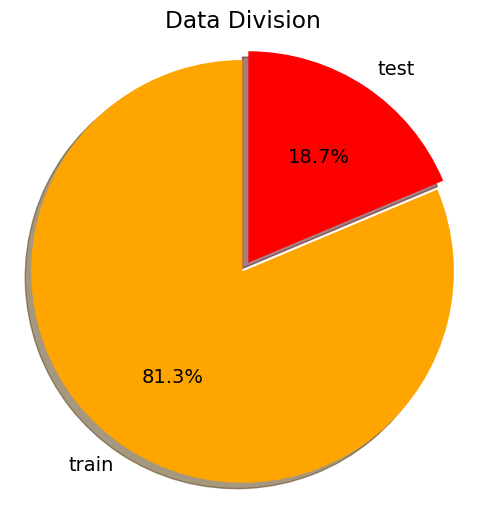

5712 1311


In [13]:
# That is the proportion of train and test

# The total number of pictures in train and test
train_size=sum(train_counts)
test_size= sum(test_counts)

colors = ['orange', 'red']

plt.figure(figsize=(6, 6))
plt.rcParams.update({'font.size': 14})
plt.pie([train_size, test_size], labels=['train', 'test'], colors=colors, autopct='%1.1f%%', explode=(0.05, 0),
        startangle=90, shadow=True)
plt.title('Data Division')
plt.axis('equal')
plt.show()

print(train_size, test_size)

## Lets see some samples of the classes

### Example of Normal brain

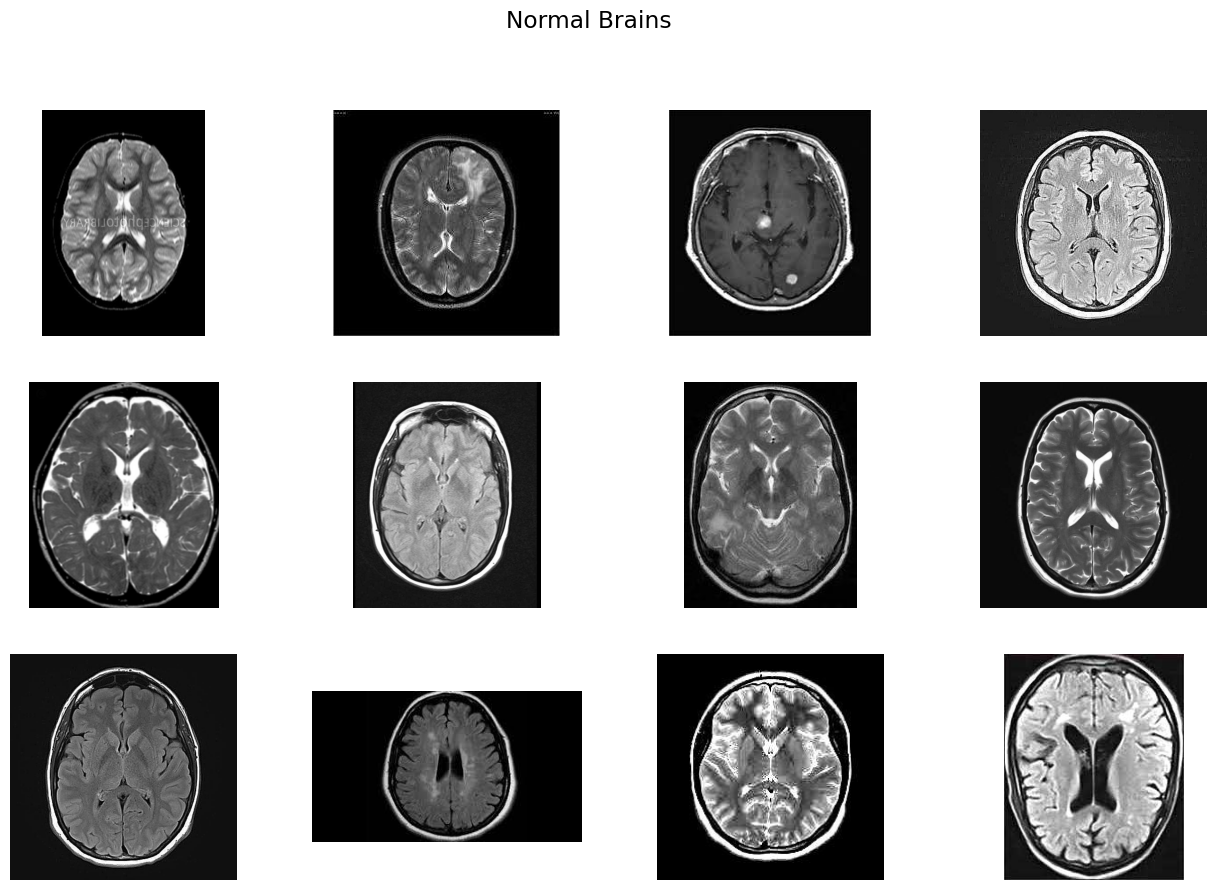

In [14]:
notumor_dir = 'Training/notumor'

# Get a list of all image files in the "notumor" category
image_files = os.listdir(notumor_dir)

# Randomly select 9 images
selected_images = random.sample(image_files, 12)

fig = plt.figure(figsize=(16, 10))
fig.suptitle('Normal Brains')

for i, filename in enumerate(selected_images):
    ax = plt.subplot(3,4, i + 1)
    img = cv2.imread(os.path.join(notumor_dir, filename))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')

plt.show()

### Glioma Tumor

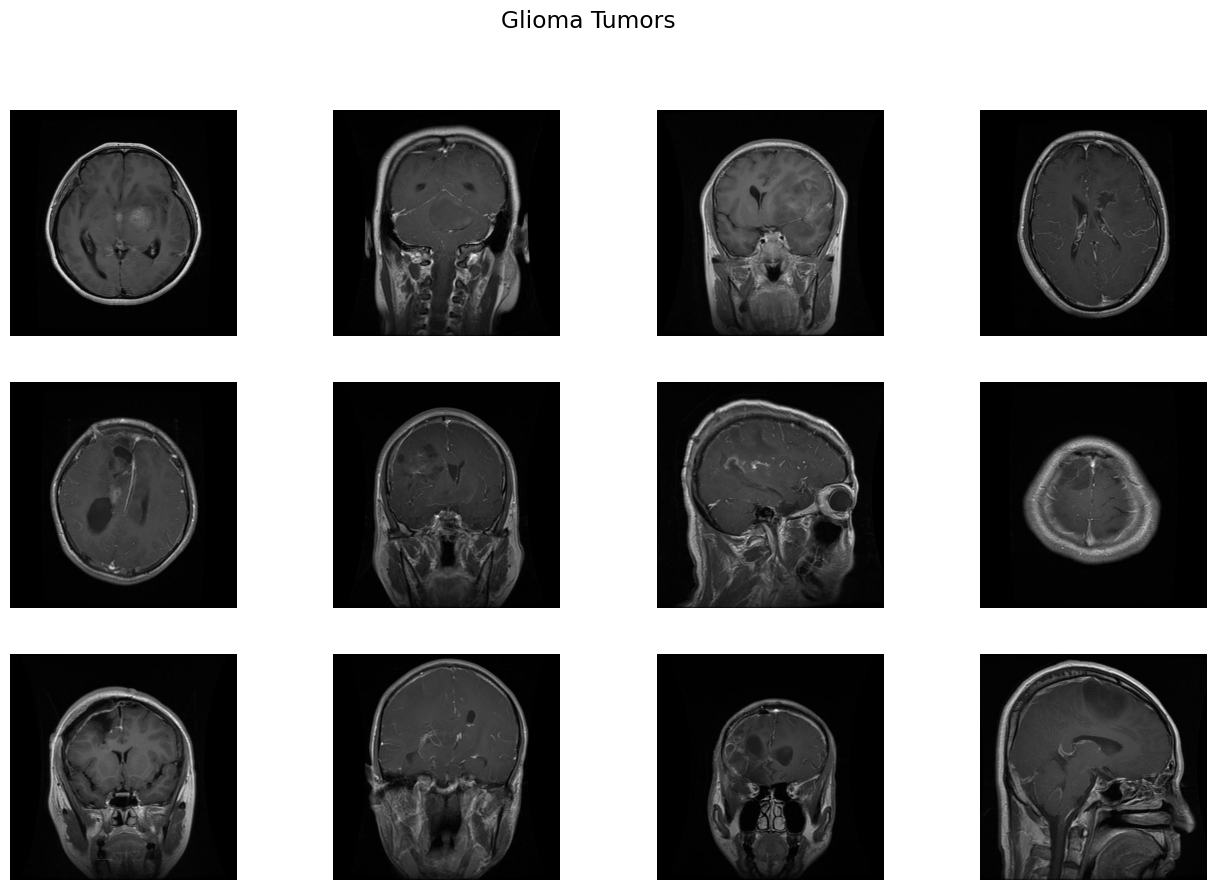

In [15]:
notumor_dir = 'Training/glioma'

# Get a list of all image files in the "notumor" category
image_files = os.listdir(notumor_dir)

# Randomly select 9 images
selected_images = random.sample(image_files, 12)

fig = plt.figure(figsize=(16, 10))
fig.suptitle('Glioma Tumors')

for i, filename in enumerate(selected_images):
    ax = plt.subplot(3,4, i + 1)
    img = cv2.imread(os.path.join(notumor_dir, filename))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')

plt.show()

### Meningioma Tumor

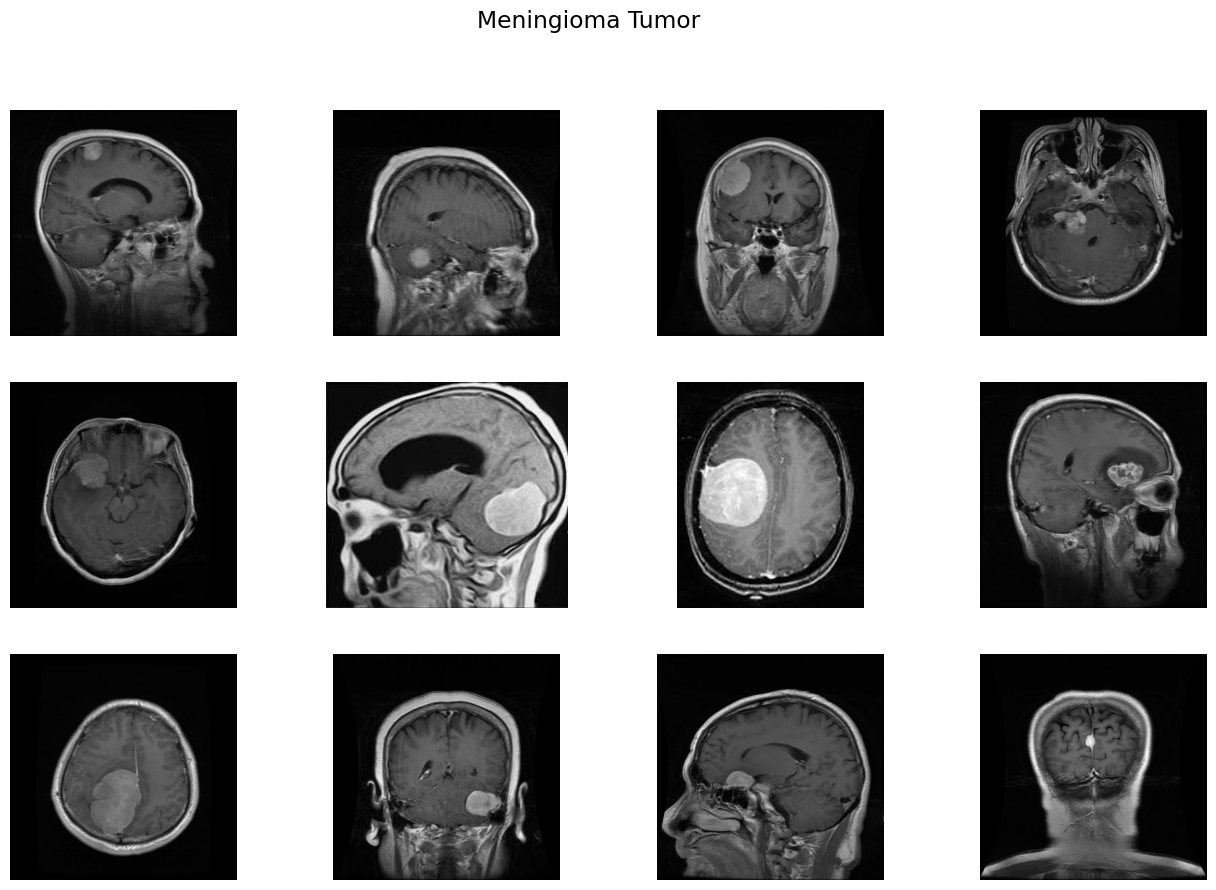

In [16]:
meningioma_dir = 'Training/meningioma'

# Get a list of all image files in the "notumor" category
image_files = os.listdir(meningioma_dir )

# Randomly select 9 images
selected_images = random.sample(image_files, 12)

fig = plt.figure(figsize=(16, 10))
fig.suptitle('Meningioma Tumor')

x=10

for i, filename in enumerate(selected_images):
    ax = plt.subplot(3, 4, i + 1)
    img = cv2.imread(os.path.join(meningioma_dir , filename))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')

plt.show()


### Pituitary Tumor

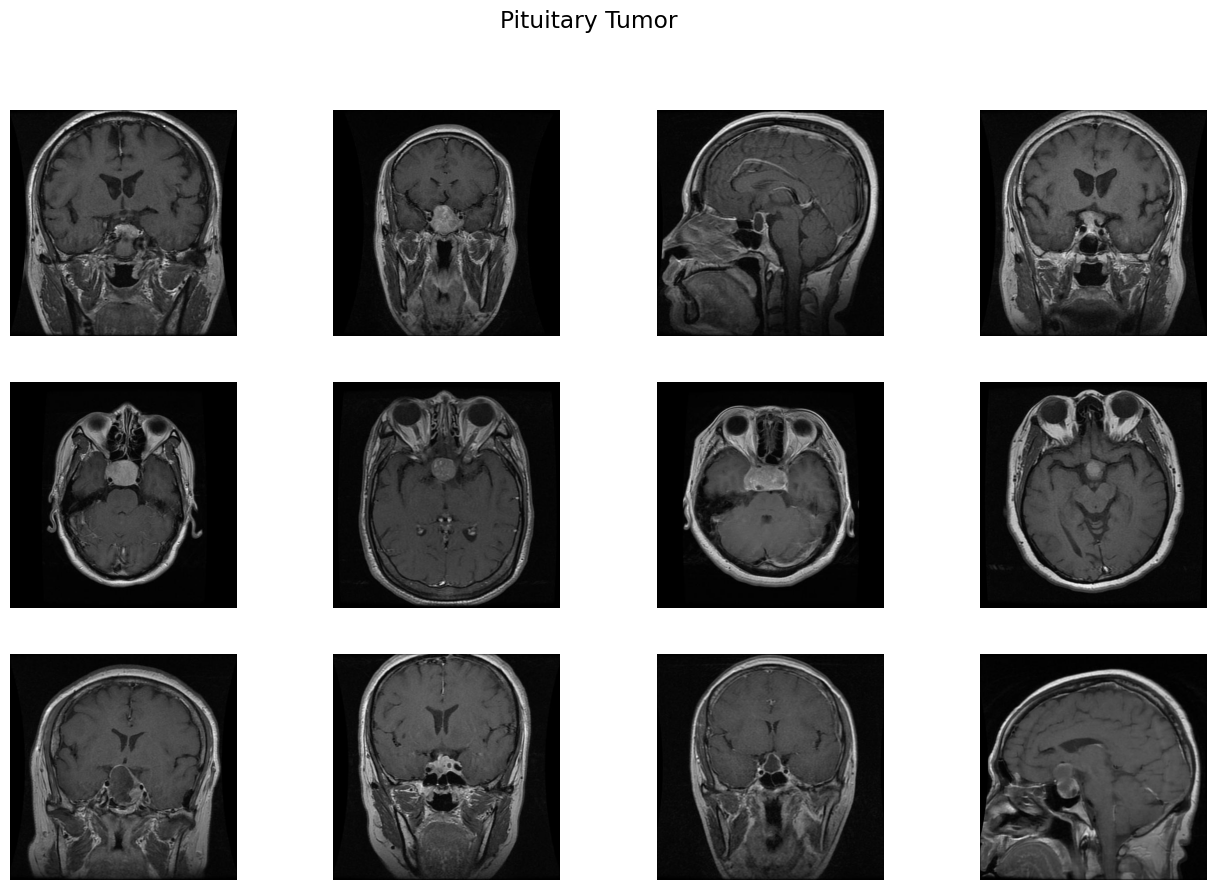

In [17]:
pituitary_dir = 'Training/pituitary'

# Get a list of all image files in the "notumor" category
image_files = os.listdir(pituitary_dir )

# Randomly select 9 images
selected_images = random.sample(image_files, 12)

fig = plt.figure(figsize=(16, 10))
fig.suptitle('Pituitary Tumor')

x=10

for i, filename in enumerate(selected_images):
    ax = plt.subplot(3, 4, i + 1)
    img = cv2.imread(os.path.join(pituitary_dir , filename))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')

plt.show()


In [18]:
#Image resize to 128 to 128
img_size = 128
image_array_train = cv2.resize(img_array_train, (img_size,img_size))
image_array_test = cv2.resize(img_array_test, (img_size,img_size))

In [19]:
gt1 = cv2.imread(train_dir+'glioma/Tr-gl_0028.jpg')
mt1 = cv2.imread(train_dir+'meningioma/Tr-me_0030.jpg')
nt1 = cv2.imread(train_dir+'notumor/Tr-no_0035.jpg')
pt1 = cv2.imread(train_dir+'pituitary/Tr-pi_0038.jpg')

## Convert each image to grayscale and append into an array

In [20]:
#Conversion to gray scale image using cv2.IMREAD_GRAYSCALE argument and creation of train data
#Each element of list contains image vector representation in place 0 and classification label in place 1
train_data = []

for i in categories:
    train_path = os.path.join(train_dir,i)
    tag = categories.index(i)
    for img in os.listdir(train_path):
        try:
            image_arr = cv2.imread(os.path.join(train_path , img), cv2.IMREAD_GRAYSCALE)
            new_image_array = cv2.resize(image_arr, (img_size,img_size))
            train_data.append([new_image_array , tag])
        except Exception as e:
            pass

In [21]:
# convert to gray scale the test array
test_data = []

for i in categories:
    test_path = os.path.join(test_dir,i)
    tag = categories.index(i)
    for img in os.listdir(test_path):
        try:
            image_arr = cv2.imread(os.path.join(test_path , img), cv2.IMREAD_GRAYSCALE)
            new_image_array = cv2.resize(image_arr, (img_size,img_size))
            test_data.append([new_image_array , tag])
        except Exception as e:
            pass


## Split the features and target in to X and y

In [22]:
#Train data
X = []
y = []
for i,j in train_data:
    X.append(i)
    y.append(j)
X = np.array(X).reshape(-1,img_size,img_size)
print(X.shape)
#print(X[0])
X = X/255.0
#print(X[0])
X = X.reshape(-1,128,128,1)
print(X.shape)


(5712, 128, 128)
(5712, 128, 128, 1)


In [23]:


y_train = to_categorical(y, num_classes = 4)

In [24]:
# Test data
X_test = []
y_test = []
for i,j in test_data:
    X_test.append(i)
    y_test.append(j)
X_test = np.array(X_test).reshape(-1,img_size,img_size)
print(X_test.shape)

X_test = X_test/255.0

X_test = X_test.reshape(-1,128,128,1)
print(X_test.shape)



(1311, 128, 128)
(1311, 128, 128, 1)


In [25]:
y_test = to_categorical(y_test, num_classes = 4)
print(np.array(y_test).shape)

(1311, 4)


### Split the data into Train, Validation  (80%-20%)

In [26]:

X_train , X_val, y_train, y_val = train_test_split(X , y , test_size = 0.2, random_state = 42)
num_classes = 4
y_train = to_categorical(y_train, num_classes=num_classes)
y_val = to_categorical(y_val, num_classes=num_classes)

# Check the shapes of the resulting arrays
print(X_train.shape)
print(X_val.shape)
print(np.array(y_train).shape)
print(np.array(y_val).shape)



(4569, 128, 128, 1)
(1143, 128, 128, 1)
(4569, 4)
(1143, 4)


## Import keras' functions to create CNN model

In [27]:
# Create a list to store the results
results = []


# Define a function to run and evaluate each model
def run_model_and_evaluate(model_name, model):
    # Train the model and measure the training time
    start_time = time.time()
    # ... Train the model ...
    training_time = time.time() - start_time

    # After training, calculate the metrics (accuracy, recall, precision, f1 score)
    # ... Calculate the metrics ...

    # Store the results in a dictionary
    result = {
        'Model Name': model_name,
        'Accuracy': accuracy,
        'Recall': recall,
        'Precision': precision,
        'F1 Score': f1_score,
        'Training Time': training_time
    }

    # Append the result dictionary to the result_list
    result_list.append(result)

# Run and evaluate each model
# Replace 'model1', 'model2', etc. with your actual model instances or functions
run_model_and_evaluate('CNN', model1)
run_model_and_evaluate('CNN + XGBoost', model2)
run_model_and_evaluate('VGG16', model3)
run_model_and_evaluate('SEGMENTATION', model4)
# Create a DataFrame from the results
df_results = pd.DataFrame(results)

# Display the DataFrame
df_results

NameError: ignored

In [28]:
!pip install pydot

In [29]:
!pip install graphviz

In [54]:
# Create a list to store the results
results = []

model = Sequential()


model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (128,128,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))


model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(1024, activation = "relu"))
model.add(Dropout(0.5))

model.add(Dense(4, activation = "softmax"))

optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

epochs = 12

es = EarlyStopping(
    monitor='loss',
    mode='max',
    patience = 15
)

batch_size = 16
imggen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=0,
        zoom_range = 0,
        width_shift_range=0,
        height_shift_range=0,
        horizontal_flip=True,
        vertical_flip=False)

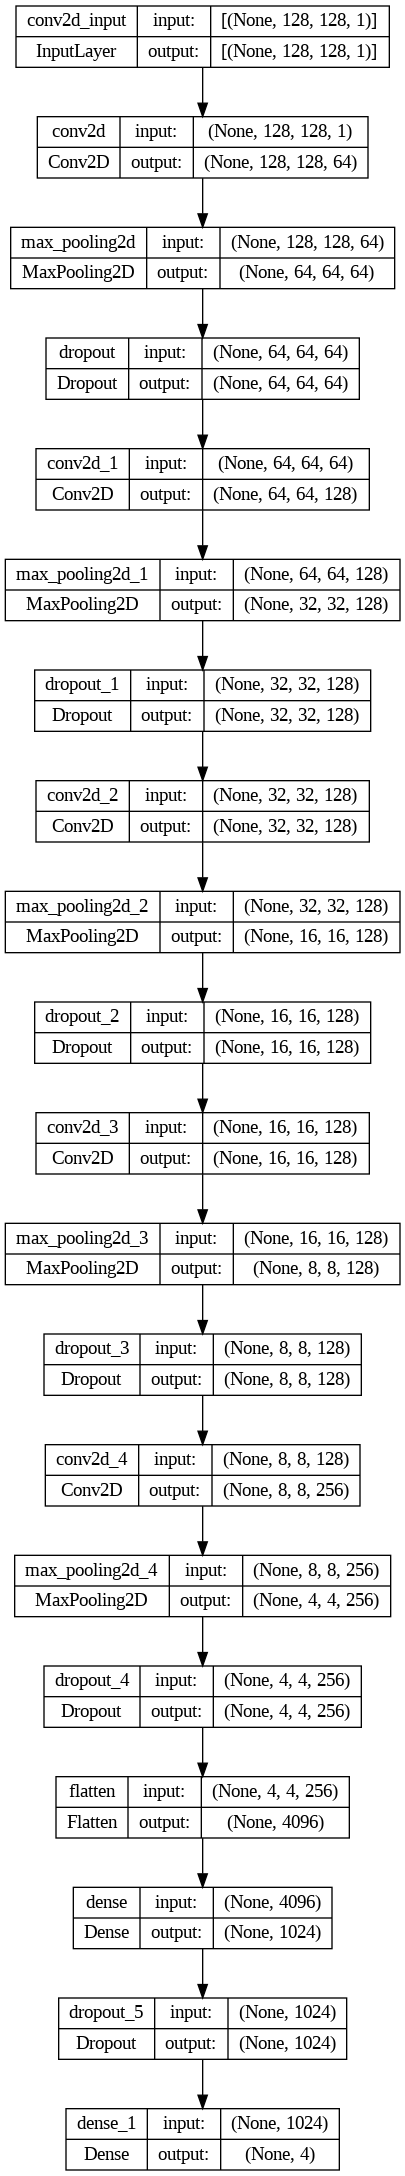

In [31]:
plot_model(model, show_shapes=True, show_layer_names=True)

## Fit the model with Train and Validation datatsets

In [41]:

start_time = time.time()

# Fitting the model to the data
history = model.fit(
        imggen.flow(X_train, y_train, batch_size=batch_size),
        epochs=epochs,
        validation_data=(X_val, y_val),
        steps_per_epoch=X_train.shape[0] // batch_size,
        callbacks=[es]
    )

training_time = time.time() - start_time


Epoch 1/12
285/285 [==============================] - 7s 26ms/step - loss: 0.1079 - accuracy: 0.9635 - val_loss: 0.1020 - val_accuracy: 0.9641
Epoch 2/12
285/285 [==============================] - 7s 25ms/step - loss: 0.1096 - accuracy: 0.9624 - val_loss: 0.1210 - val_accuracy: 0.9633
Epoch 3/12
285/285 [==============================] - 7s 25ms/step - loss: 0.0969 - accuracy: 0.9679 - val_loss: 0.1607 - val_accuracy: 0.9458
Epoch 4/12
285/285 [==============================] - 7s 24ms/step - loss: 0.0808 - accuracy: 0.9725 - val_loss: 0.1174 - val_accuracy: 0.9676
Epoch 5/12
285/285 [==============================] - 7s 25ms/step - loss: 0.0895 - accuracy: 0.9710 - val_loss: 0.1354 - val_accuracy: 0.9589
Epoch 6/12
285/285 [==============================] - 7s 25ms/step - loss: 0.0897 - accuracy: 0.9697 - val_loss: 0.3032 - val_accuracy: 0.9099
Epoch 7/12
285/285 [==============================] - 7s 25ms/step - loss: 0.0938 - accuracy: 0.9668 - val_loss: 0.1190 - val_accuracy: 0.9694

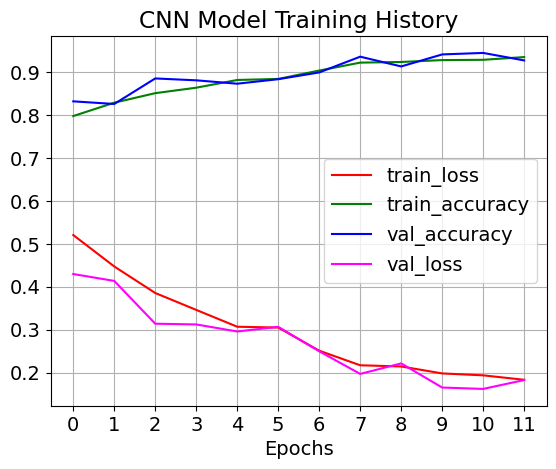

In [38]:
plt.plot(history.history["loss"],c = "red")
plt.plot(history.history["accuracy"],c = "green")
plt.plot(history.history['val_accuracy'], c = "blue")
plt.plot(history.history['val_loss'], c = "magenta")
plt.grid(True)
plt.title("CNN Model Training History")
plt.xlabel("Epochs")
plt.xticks([x for x in range(epochs)])
plt.legend(["train_loss", "train_accuracy",'val_accuracy','val_loss'])
plt.rcParams["figure.figsize"] = (7,8)
plt.show()

## Validation with test samples

In [42]:
score=model.evaluate(X_test, y_test, verbose=0)
print('Test loss', score[0])
print('Test accuracy:',score[1])

Test loss 0.1047794371843338
Test accuracy: 0.9687261581420898


In [43]:
# Make predictions on the test data
y_pred_prob = model.predict(X_test)

# Convert predicted probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# If your y_test is one-hot encoded, you may need to convert it to class labels as well
y_true = np.argmax(y_test, axis=1)


# Generate the classification report
report = classification_report(y_true, y_pred)

# Print the classification report
print(report)

41/41 [==============================] - 1s 10ms/step
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       300
           1       0.96      0.93      0.94       306
           2       0.99      0.99      0.99       405
           3       0.96      0.99      0.97       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



## Generate the confusion matrix

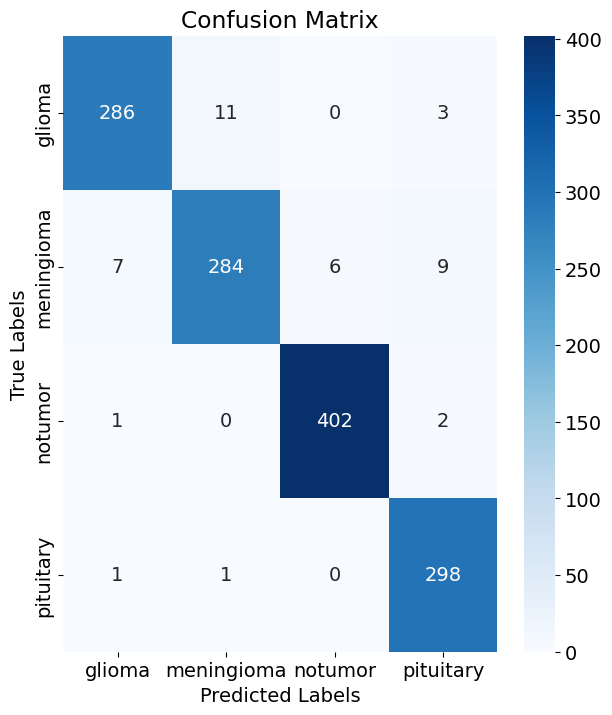

In [44]:

conf_matrix = confusion_matrix(y_true, y_pred)

# Define class labels (if you have specific class labels)
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']
class_labels = categories

# Create a heatmap using Seaborn
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

In [55]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Calculate precision
precision = precision_score(y_true, y_pred, average='weighted')  # or 'macro' or 'micro' depending on your needs

# Calculate recall
recall = recall_score(y_true, y_pred, average='weighted')  # or 'macro' or 'micro' depending on your needs

# Calculate F1 score
f1 = f1_score(y_true, y_pred, average='weighted')  # or 'macro' or 'micro' depending on your needs

# Store the results in a dictionary
result = {
        'Model Name': 'CNN',
        'Accuracy': accuracy,
        'Recall': recall,
        'Precision': precision,
        'F1 Score': f1,
        'Training Time': training_time
    }

    # Append the result dictionary to the result_list
results.append(result)

# # Run and evaluate each model
# # Replace 'model1', 'model2', etc. with your actual model instances or functions
# run_model_and_evaluate('CNN', model1)
# run_model_and_evaluate('CNN + XGBoost', model2)
# run_model_and_evaluate('VGG16', model3)
# run_model_and_evaluate('SEGMENTATION', model4)
# # Create a DataFrame from the results
df_results = pd.DataFrame(results)

# Display the DataFrame
df_results


,Model Name,Accuracy,Recall,Precision,F1 Score,Training Time
0,CNN,0.968726,0.968726,0.968745,0.968569,95.363956


## Save the trained model

In [56]:
# Save the entire model (architecture, weights, and optimizer state) to a file
model.save("CNN_Brain_trained.h5")


## Load the pretrained model to use it further

In [57]:
# To load the entire model (architecture, weights, and optimizer state) from the saved file
cnn_model = tf.keras.models.load_model("CNN_Brain_trained.h5")

# Get the output probabilities for the test data
y_proba = cnn_model.predict(X_test)

y_proba.shape

41/41 [==============================] - 1s 10ms/step


(1311, 4)

## Lets make an ensemble modeling by applying the results to XGBoost

In [60]:
# Create a new model that outputs the output of the dense_2 layer
layer_name = 'dense_2'  #
new_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

# Use the new model to extract features from your input data
X_train_features = new_model.predict(X_train)
X_test_features = new_model.predict(X_test)

print(X_train_features.shape)
print(X_test_features.shape)


41/41 [==============================] - 0s 6ms/step
(4569, 1024)
(1311, 1024)


In [61]:
y_pred = np.argmax(y_proba, axis=1)

In [62]:
from xgboost import XGBClassifier


In [65]:
start_time = time.time()

xgb = XGBClassifier(objective='multiclass:softmax', learning_rate = 0.1,
              max_depth = 15, n_estimators = 500)
xgb.fit(X_train_features,np.argmax(y_train, axis=1))


training_time = time.time() - start_time

In [66]:
XGBClassifier(max_depth=15, n_estimators=500, objective='multi:softprob')

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [67]:

X_test_features = new_model.predict(X_test)

41/41 [==============================] - 0s 8ms/step


In [68]:

y_pred = xgb.predict(X_test_features)

In [69]:
y_test = np.argmax(y_test, axis =1)

In [70]:

from sklearn.metrics import accuracy_score as ac
ac(y_pred, y_test)

0.8909229595728452

In [71]:
# Generate the classification report
report = classification_report(y_true, y_pred)

# Print the classification report
print(report)

              precision    recall  f1-score   support

           0       0.89      0.79      0.84       300
           1       0.80      0.79      0.80       306
           2       0.95      0.99      0.97       405
           3       0.91      0.95      0.93       300

    accuracy                           0.89      1311
   macro avg       0.89      0.88      0.88      1311
weighted avg       0.89      0.89      0.89      1311



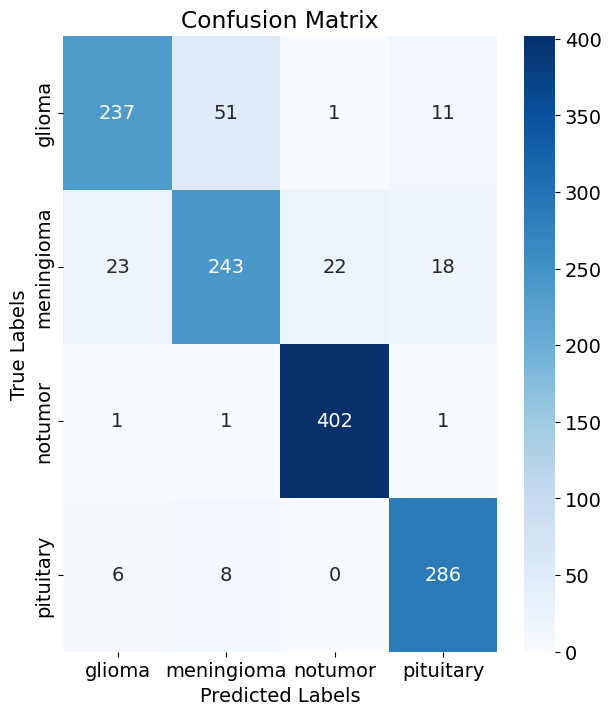

In [72]:
conf_matrix = confusion_matrix(y_true, y_pred)

# Define class labels (if you have specific class labels)
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']
class_labels = categories


# Create a heatmap using Seaborn
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

In [73]:
# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Calculate precision
precision = precision_score(y_true, y_pred, average='weighted')  # or 'macro' or 'micro' depending on your needs

# Calculate recall
recall = recall_score(y_true, y_pred, average='weighted')  # or 'macro' or 'micro' depending on your needs

# Calculate F1 score
f1 = f1_score(y_true, y_pred, average='weighted')  # or 'macro' or 'micro' depending on your needs

# Store the results in a dictionary
result = {
        'Model Name': 'CNN +XGBoost',
        'Accuracy': accuracy,
        'Recall': recall,
        'Precision': precision,
        'F1 Score': f1,
        'Training Time': training_time
    }

    # Append the result dictionary to the result_list
results.append(result)

# # Run and evaluate each model
# # Replace 'model1', 'model2', etc. with your actual model instances or functions
# run_model_and_evaluate('CNN', model1)
# run_model_and_evaluate('CNN + XGBoost', model2)
# run_model_and_evaluate('VGG16', model3)
# run_model_and_evaluate('SEGMENTATION', model4)
# # Create a DataFrame from the results
df_results = pd.DataFrame(results)

# Display the DataFrame
df_results


,Model Name,Accuracy,Recall,Precision,F1 Score,Training Time
0,CNN,0.968726,0.968726,0.968745,0.968569,95.363956
1,CNN +XGBoost,0.890923,0.890923,0.889626,0.889302,675.464786


# UniverSeq - Segmentation model

###The role of the support set is crucial for the UniverSeq model, as it enables the model to learn a good representation of the object classes from the limited labeled samples. During inference, the UniverSeq model will use the support set information to segment objects in the test set, even if it has not seen examples of those classes during training.

In [ ]:
# Manually select the image filenames you want to include in the support_notumor set
selected_filenames = ["Tr-no_0047", "Tr-no_0049"]

# Create an empty list to hold the support_notumor images and labels
support_notumor_images = []
support_notumor_labels = []

# Loop through the training dataset and select the desired images
for image, label in training_dataset:
    # Check if the image filename is in the selected_filenames list
    if image.filename in selected_filenames:
        # Add the image and label to the support_notumor set
        support_notumor_images.append(image)
        support_notumor_labels.append(label)

# Now you have the selected images and labels in the support_notumor set.
# You can convert them into tensors or other suitable formats as needed.